# Create Balanced Target Distribution Dataset

This notebook analyzes the current target distribution in `train.parquet` and creates a new balanced dataset where all target categories (0, 0.25, 0.5, 0.75, 1) have equal probability.

**Current Distribution (estimated):**
- 0.5 (middle): ~40%
- 0.25, 0.75: ~20% each
- 0, 1 (extremes): ~5% each

**Target Distribution:**
- All categories: 20% each (equal probability)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Configure matplotlib
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the training dataset
data_path = "../../data/train.parquet"
print(f"Loading dataset from: {data_path}")

if os.path.exists(data_path):
    df = pd.read_parquet(data_path)
    print(f"Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
else:
    print(f"File not found: {data_path}")
    print("Please check the file path.")

Loading dataset from: ../../data/train.parquet
Dataset loaded successfully!
Shape: (2746270, 2415)
Columns: ['era', 'data_type', 'feature_shaded_hallucinatory_dactylology', 'feature_itinerant_hexahedral_photoengraver', 'feature_prudent_pileate_oven', 'feature_subalpine_apothegmatical_ajax', 'feature_pistachio_atypical_malison', 'feature_symmetrical_spongy_tricentenary', 'feature_ungrounded_transpontine_winder', 'feature_aseptic_eely_hemiplegia', 'feature_elemental_easier_alkalinity', 'feature_cycloid_zymotic_galloway', 'feature_untidier_cherished_abbacy', 'feature_paracelsian_capable_cosmography', 'feature_eliminative_social_remonetization', 'feature_phototactic_dire_ethnarchy', 'feature_frozen_tellurian_pentameter', 'feature_sassy_coseismic_deadlock', 'feature_computational_contradictable_misguidance', 'feature_fatalistic_brooding_fitzgerald', 'feature_sprucest_alsatian_shade', 'feature_zincy_cirrhotic_josh', 'feature_grainy_demersal_consuetude', 'feature_flittering_remunerative_hand'


=== TARGET DISTRIBUTION ANALYSIS ===

Target column statistics:
count    2.746270e+06
mean     5.000268e-01
std      2.231753e-01
min      0.000000e+00
25%      2.500000e-01
50%      5.000000e-01
75%      5.000000e-01
max      1.000000e+00
Name: target, dtype: float64

Unique target values: [0.0, 0.25, 0.5, 0.75, 1.0]
Number of unique values: 5

Target value distribution:
 Target   Count  Percentage
   0.00  135668        4.94
   0.25  550995       20.06
   0.50 1373108       50.00
   0.75  550373       20.04
   1.00  136126        4.96
count    2.746270e+06
mean     5.000268e-01
std      2.231753e-01
min      0.000000e+00
25%      2.500000e-01
50%      5.000000e-01
75%      5.000000e-01
max      1.000000e+00
Name: target, dtype: float64

Unique target values: [0.0, 0.25, 0.5, 0.75, 1.0]
Number of unique values: 5

Target value distribution:
 Target   Count  Percentage
   0.00  135668        4.94
   0.25  550995       20.06
   0.50 1373108       50.00
   0.75  550373       20.04
   1.

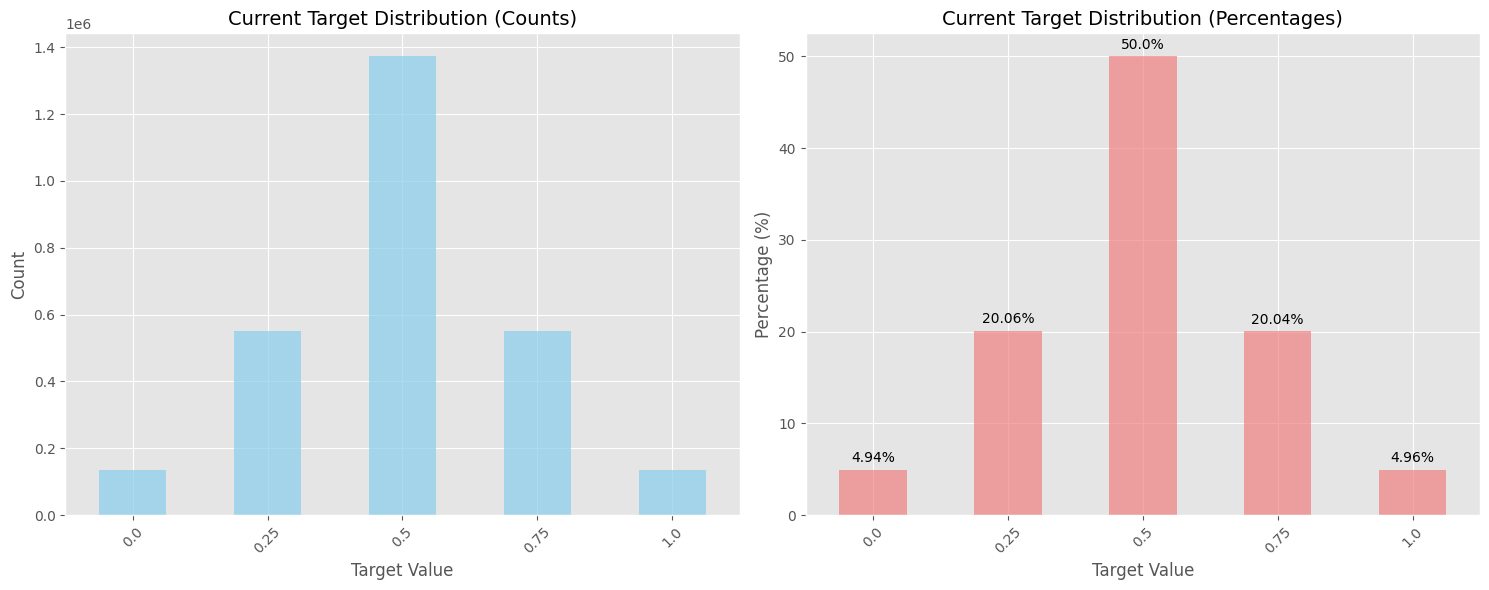

In [3]:
# Analyze the target distribution
if 'df' in locals():
    print("\n=== TARGET DISTRIBUTION ANALYSIS ===")
    
    # Basic statistics
    print(f"\nTarget column statistics:")
    print(df['target'].describe())
    
    # Check unique values
    unique_targets = sorted(df['target'].unique())
    print(f"\nUnique target values: {unique_targets}")
    print(f"Number of unique values: {len(unique_targets)}")
    
    # Count occurrences of each target value
    target_counts = df['target'].value_counts().sort_index()
    target_percentages = (target_counts / len(df) * 100).round(2)
    
    print(f"\nTarget value distribution:")
    distribution_df = pd.DataFrame({
        'Target': target_counts.index,
        'Count': target_counts.values,
        'Percentage': target_percentages.values
    })
    print(distribution_df.to_string(index=False))
    
    # Visualize the distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Count plot
    target_counts.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.7)
    ax1.set_title('Current Target Distribution (Counts)')
    ax1.set_xlabel('Target Value')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)
    
    # Percentage plot
    target_percentages.plot(kind='bar', ax=ax2, color='lightcoral', alpha=0.7)
    ax2.set_title('Current Target Distribution (Percentages)')
    ax2.set_xlabel('Target Value')
    ax2.set_ylabel('Percentage (%)')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add percentage labels on bars
    for i, v in enumerate(target_percentages.values):
        ax2.text(i, v + 0.5, f'{v}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
else:
    print("Dataset not loaded. Please run the previous cell first.")

In [4]:
# Create balanced dataset
if 'df' in locals():
    print("\n=== CREATING BALANCED DATASET ===")
    
    # Get target value counts
    target_counts = df['target'].value_counts().sort_index()
    print(f"\nOriginal counts per target value:")
    for target, count in target_counts.items():
        print(f"  {target}: {count:,} samples")
    
    # Find the minimum count (this will be our target count for all categories)
    min_count = target_counts.min()
    print(f"\nMinimum count found: {min_count:,}")
    print(f"This will be the target count for all categories.")
    
    # Create balanced dataset by sampling min_count from each category
    balanced_dfs = []
    
    for target_value in sorted(df['target'].unique()):
        # Get all samples for this target value
        target_samples = df[df['target'] == target_value]
        
        # Sample min_count samples (or all if less than min_count)
        if len(target_samples) >= min_count:
            sampled = target_samples.sample(n=min_count, random_state=42)
            print(f"  Target {target_value}: sampled {len(sampled):,} from {len(target_samples):,}")
        else:
            sampled = target_samples
            print(f"  Target {target_value}: using all {len(sampled):,} samples")
        
        balanced_dfs.append(sampled)
    
    # Combine all balanced samples
    balanced_df = pd.concat(balanced_dfs, ignore_index=True)
    
    # Shuffle the dataset
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"\nBalanced dataset created!")
    print(f"Original size: {len(df):,} samples")
    print(f"Balanced size: {len(balanced_df):,} samples")
    print(f"Reduction: {(1 - len(balanced_df)/len(df))*100:.1f}%")
else:
    print("Dataset not loaded. Please run the previous cells first.")


=== CREATING BALANCED DATASET ===

Original counts per target value:
  0.0: 135,668 samples
  0.25: 550,995 samples
  0.5: 1,373,108 samples
  0.75: 550,373 samples
  1.0: 136,126 samples

Minimum count found: 135,668
This will be the target count for all categories.
  Target 0.0: sampled 135,668 from 135,668
  Target 0.0: sampled 135,668 from 135,668
  Target 0.25: sampled 135,668 from 550,995
  Target 0.25: sampled 135,668 from 550,995
  Target 0.5: sampled 135,668 from 1,373,108
  Target 0.5: sampled 135,668 from 1,373,108
  Target 0.75: sampled 135,668 from 550,373
  Target 0.75: sampled 135,668 from 550,373
  Target 1.0: sampled 135,668 from 136,126
  Target 1.0: sampled 135,668 from 136,126

Balanced dataset created!
Original size: 2,746,270 samples
Balanced size: 678,340 samples
Reduction: 75.3%

Balanced dataset created!
Original size: 2,746,270 samples
Balanced size: 678,340 samples
Reduction: 75.3%



=== BALANCED DATASET VERIFICATION ===

New target value distribution:
 Target  Count  Percentage
   0.00 135668        20.0
   0.25 135668        20.0
   0.50 135668        20.0
   0.75 135668        20.0
   1.00 135668        20.0

Comparison - Original vs Balanced:
 Target  Original_Count  Original_Pct  Balanced_Count  Balanced_Pct
   0.00          135668          4.94          135668          20.0
   0.25          550995         20.06          135668          20.0
   0.50         1373108         50.00          135668          20.0
   0.75          550373         20.04          135668          20.0
   1.00          136126          4.96          135668          20.0


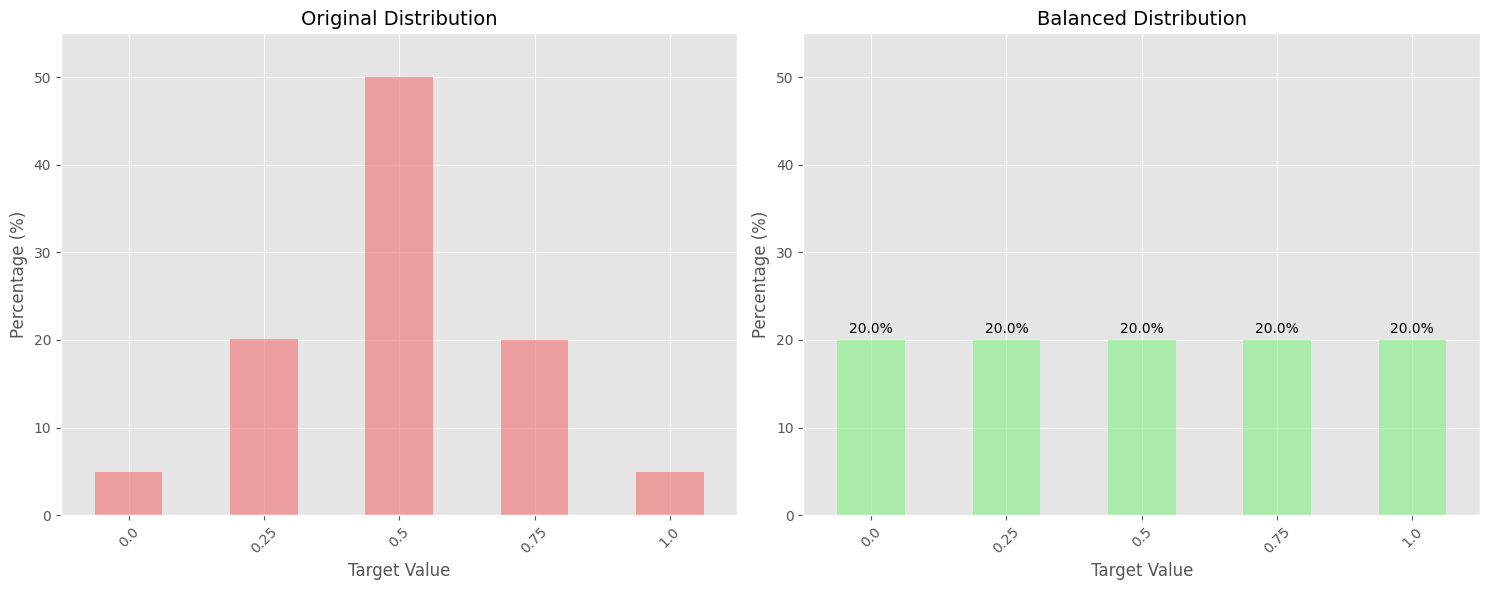


Is the dataset perfectly balanced? True
✅ All target categories have exactly 135,668 samples each!


In [5]:
# Verify the balanced distribution
if 'balanced_df' in locals():
    print("\n=== BALANCED DATASET VERIFICATION ===")
    
    # Check new distribution
    new_target_counts = balanced_df['target'].value_counts().sort_index()
    new_target_percentages = (new_target_counts / len(balanced_df) * 100).round(2)
    
    print(f"\nNew target value distribution:")
    new_distribution_df = pd.DataFrame({
        'Target': new_target_counts.index,
        'Count': new_target_counts.values,
        'Percentage': new_target_percentages.values
    })
    print(new_distribution_df.to_string(index=False))
    
    # Compare original vs balanced
    comparison_df = pd.DataFrame({
        'Target': sorted(df['target'].unique()),
        'Original_Count': [target_counts.get(t, 0) for t in sorted(df['target'].unique())],
        'Original_Pct': [target_percentages.get(t, 0) for t in sorted(df['target'].unique())],
        'Balanced_Count': [new_target_counts.get(t, 0) for t in sorted(df['target'].unique())],
        'Balanced_Pct': [new_target_percentages.get(t, 0) for t in sorted(df['target'].unique())]
    })
    
    print(f"\nComparison - Original vs Balanced:")
    print(comparison_df.to_string(index=False))
    
    # Visualize comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original distribution
    target_percentages.plot(kind='bar', ax=ax1, color='lightcoral', alpha=0.7)
    ax1.set_title('Original Distribution')
    ax1.set_xlabel('Target Value')
    ax1.set_ylabel('Percentage (%)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_ylim(0, max(target_percentages.max(), new_target_percentages.max()) + 5)
    
    # Balanced distribution
    new_target_percentages.plot(kind='bar', ax=ax2, color='lightgreen', alpha=0.7)
    ax2.set_title('Balanced Distribution')
    ax2.set_xlabel('Target Value')
    ax2.set_ylabel('Percentage (%)')
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_ylim(0, max(target_percentages.max(), new_target_percentages.max()) + 5)
    
    # Add percentage labels
    for i, v in enumerate(new_target_percentages.values):
        ax2.text(i, v + 0.5, f'{v}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Check if distribution is truly balanced
    is_balanced = len(set(new_target_counts.values)) == 1
    print(f"\nIs the dataset perfectly balanced? {is_balanced}")
    if is_balanced:
        print(f"✅ All target categories have exactly {new_target_counts.iloc[0]:,} samples each!")
    else:
        print(f"⚠️ Some variation in counts: {dict(new_target_counts)}")
else:
    print("Balanced dataset not created. Please run the previous cells first.")

In [7]:
# Save the balanced dataset
if 'balanced_df' in locals():
    print("\n=== SAVING BALANCED DATASET ===")
    
    # Create output directory if it doesn't exist
    output_dir = "../../data"
    os.makedirs(output_dir, exist_ok=True)
    
    # Define output path
    output_path = os.path.join(output_dir, "train_balanced.parquet")
    
    # Save the balanced dataset
    balanced_df.to_parquet(output_path, index=False)
    print(f"✅ Balanced dataset saved to: {output_path}")
    
    # Verify the saved file
    if os.path.exists(output_path):
        file_size = os.path.getsize(output_path) / (1024 * 1024)  # Size in MB
        print(f"File size: {file_size:.2f} MB")
        
        # Quick verification by loading and checking shape
        verification_df = pd.read_parquet(output_path)
        print(f"Verification - Shape: {verification_df.shape}")
        print(f"Verification - Target distribution: {dict(verification_df['target'].value_counts().sort_index())}")
        
        # Create a summary file
        summary_path = os.path.join(output_dir, "train_balanced_summary.txt")
        with open(summary_path, 'w') as f:
            f.write("BALANCED DATASET SUMMARY\n")
            f.write("=" * 50 + "\n\n")
            f.write(f"Original dataset: {len(df):,} samples\n")
            f.write(f"Balanced dataset: {len(balanced_df):,} samples\n")
            f.write(f"Reduction: {(1 - len(balanced_df)/len(df))*100:.1f}%\n\n")
            f.write("Target value distribution (balanced):\n")
            for target, count in verification_df['target'].value_counts().sort_index().items():
                pct = count / len(verification_df) * 100
                f.write(f"  {target}: {count:,} samples ({pct:.1f}%)\n")
            f.write(f"\nDataset saved to: {output_path}\n")
            f.write(f"Summary saved to: {summary_path}\n")
        
        print(f"📄 Summary saved to: {summary_path}")
    else:
        print(f"❌ Error: Could not verify saved file at {output_path}")
else:
    print("Balanced dataset not created. Please run the previous cells first.")


=== SAVING BALANCED DATASET ===
✅ Balanced dataset saved to: ../../data/train_balanced.parquet
File size: 591.33 MB
✅ Balanced dataset saved to: ../../data/train_balanced.parquet
File size: 591.33 MB
Verification - Shape: (678340, 2415)
Verification - Target distribution: {0.0: 135668, 0.25: 135668, 0.5: 135668, 0.75: 135668, 1.0: 135668}
📄 Summary saved to: ../../data/train_balanced_summary.txt
Verification - Shape: (678340, 2415)
Verification - Target distribution: {0.0: 135668, 0.25: 135668, 0.5: 135668, 0.75: 135668, 1.0: 135668}
📄 Summary saved to: ../../data/train_balanced_summary.txt


In [8]:
# Additional analysis
if 'balanced_df' in locals():
    print("\n=== ADDITIONAL ANALYSIS ===")
    
    # Feature preservation check
    print(f"\nFeature preservation check:")
    print(f"Original features: {df.shape[1]} columns")
    print(f"Balanced features: {balanced_df.shape[1]} columns")
    print(f"All features preserved: {set(df.columns) == set(balanced_df.columns)}")
    
    # Check data types
    print(f"\nData types consistency:")
    original_dtypes = df.dtypes
    balanced_dtypes = balanced_df.dtypes
    
    for col in df.columns:
        if col in balanced_df.columns:
            if original_dtypes[col] != balanced_dtypes[col]:
                print(f"⚠️ Data type changed for {col}: {original_dtypes[col]} -> {balanced_dtypes[col]}")
    
    print(f"✅ Data types are consistent")
    
    # Statistical comparison for key columns
    print(f"\nStatistical comparison for 'target' column:")
    print(f"Original - Mean: {df['target'].mean():.4f}, Std: {df['target'].std():.4f}")
    print(f"Balanced - Mean: {balanced_df['target'].mean():.4f}, Std: {balanced_df['target'].std():.4f}")
    
    # Memory usage comparison
    original_memory = df.memory_usage(deep=True).sum() / (1024 * 1024)  # MB
    balanced_memory = balanced_df.memory_usage(deep=True).sum() / (1024 * 1024)  # MB
    
    print(f"\nMemory usage:")
    print(f"Original: {original_memory:.2f} MB")
    print(f"Balanced: {balanced_memory:.2f} MB")
    print(f"Memory saved: {original_memory - balanced_memory:.2f} MB ({(1 - balanced_memory/original_memory)*100:.1f}%)")
    
    print(f"\n🎯 DATASET BALANCING COMPLETE!")
    print(f"The balanced dataset is ready for training with equal representation of all target categories.")
else:
    print("Balanced dataset not created. Please run the previous cells first.")


=== ADDITIONAL ANALYSIS ===

Feature preservation check:
Original features: 2415 columns
Balanced features: 2415 columns
All features preserved: True

Data types consistency:
✅ Data types are consistent

Statistical comparison for 'target' column:
Original - Mean: 0.5000, Std: 0.2232
Balanced - Mean: 0.5000, Std: 0.3536

Memory usage:
Original: 7123.81 MB
Balanced: 1712.39 MB
Memory saved: 5411.42 MB (76.0%)

🎯 DATASET BALANCING COMPLETE!
The balanced dataset is ready for training with equal representation of all target categories.

Memory usage:
Original: 7123.81 MB
Balanced: 1712.39 MB
Memory saved: 5411.42 MB (76.0%)

🎯 DATASET BALANCING COMPLETE!
The balanced dataset is ready for training with equal representation of all target categories.


## Usage Instructions

1. **Run all cells above** to create the balanced dataset
2. **Use the balanced dataset** in your training by loading `train_balanced.parquet` instead of `train.parquet`
3. **Update your training scripts** to use the new balanced dataset:

```python
# Instead of:
# df = pd.read_parquet('data/train.parquet')

# Use:
df = pd.read_parquet('data/train_balanced.parquet')
```

**Benefits of the balanced dataset:**
- Equal representation of all target categories (20% each)
- Prevents model bias towards the most frequent class (0.5)
- Better learning of patterns across all target ranges
- More robust model evaluation

**Note:** The balanced dataset is smaller than the original, but each target category is equally represented, which should lead to better model generalization across all prediction ranges.